<a href="https://colab.research.google.com/github/rhehgus02/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD_%EA%B0%80%EC%9D%B4%EB%93%9C(9)_%EB%B6%84%EB%A5%98(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **6. XGBoost**

* 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나

* 장점

    * 뛰어난 예측 성능

    * GBM 대비 빠른 수행 시간

    * 과적합 규제 기능

    * 나무 가지치기

    * 자체 내장된 교차 검증

    * 결손값 자체 처리

*  파이썬 래퍼 XGBoost 모듈: 초기의 독자적인 XGBoost 프레임워크 기반의 XGBoost

* 사이킷런 래퍼 XGBoost 모듈: 사이킷런과 연동되는 모듈 - `XGBClassifier`, `XGBRegressor`

In [ ]:
# XGBoost 설치하기
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
import xgboost
print(xgboost.__version__)

1.7.5


---

### **6-1. 파이썬 래퍼 XGBoost 하이퍼 파라미터**

* XGBoost는 GBM과 유사한 하이퍼 파라미터를 동일하게 가지고 있으며, 여기에 조기 중단, 과적합을 규제하기 위한 하이퍼 파라미터 등이 추가됨

* 일반 파라미터: 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터, 디폴트 값을 바꾸는 경우는 거의 없음

  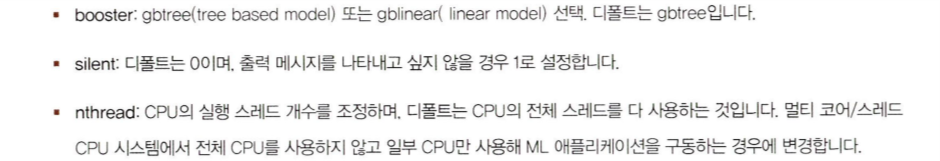

* 부스터 파라미터: 트리 최적화, 부스팅, regularization 등의 파라미터

   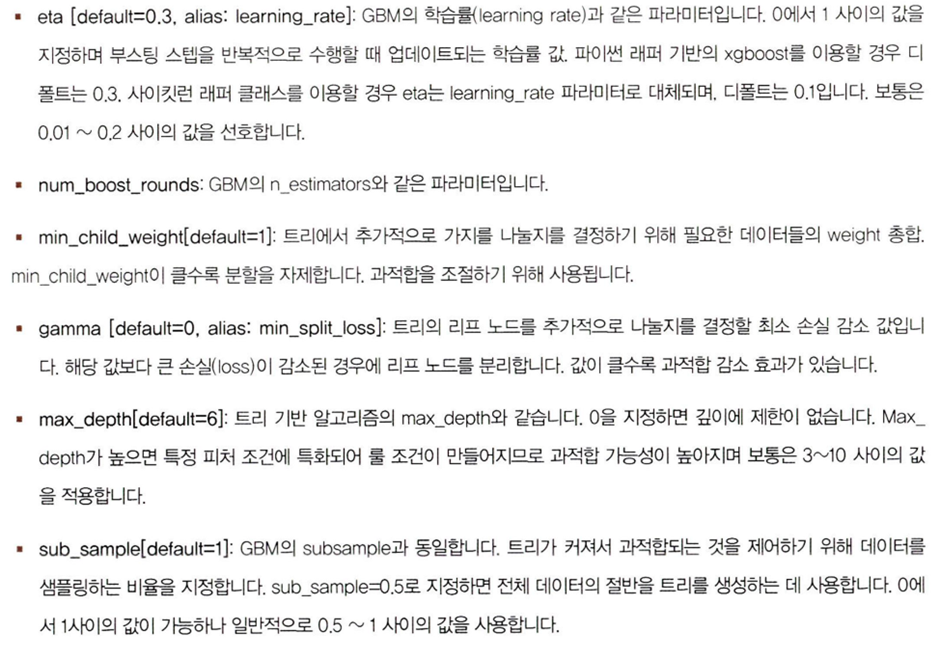

   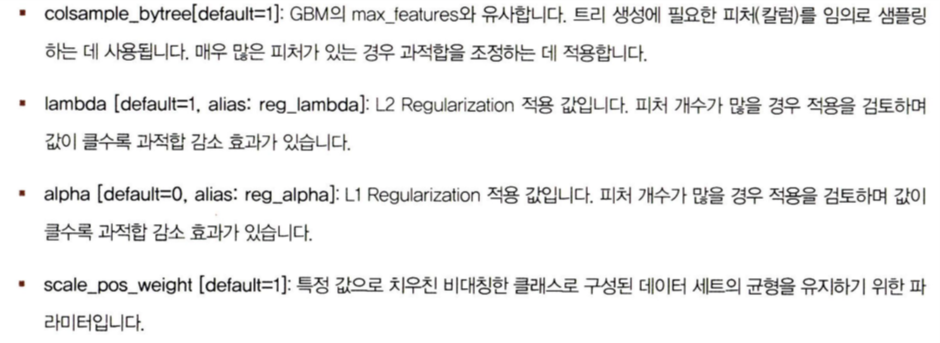

* 학습 태스크 파라미터: 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터

    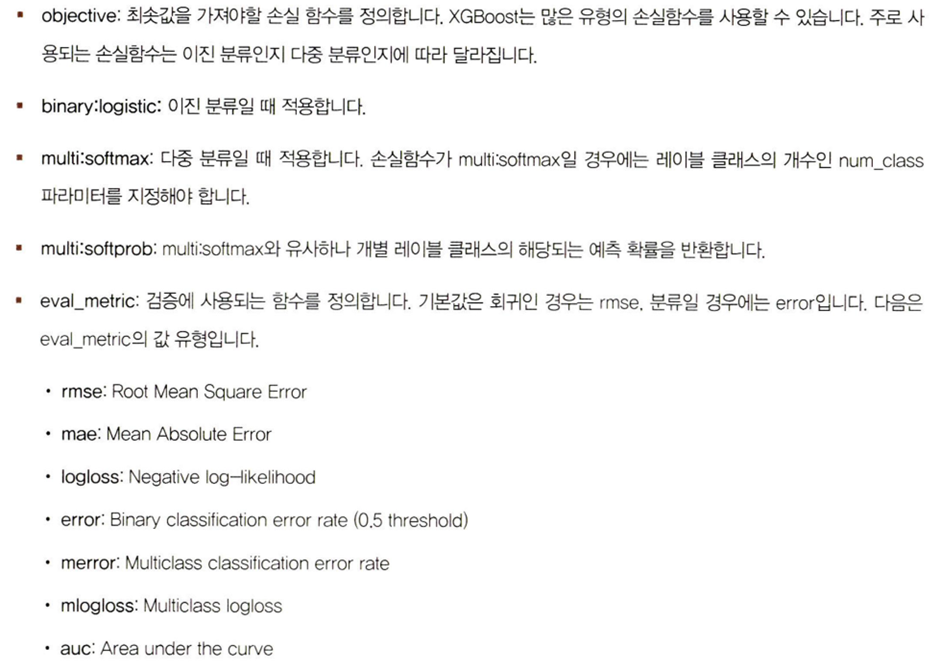

* 과적합을 방지할 수 있는 방법

    * `eta` 값을 낮추고(0.01~0.1), `n_estimators` 값을 높인다.

    * `max_depth` 값을 낮춘다.

    * `min_child_weight` 값을 높인다.

    * `gamma` 값을 높인다.

    * `subsample`과 `colsample_bytree`를 조정한다.

* XGBoost는 자체적으로 교차 검증, 성능 평가, 피처 중요도 등의 시각화 기능을 가지고 있음, 또한 기본 GBM에서 부족한 다른 여러 가지 성능 향상 기능이 있음

* 조기 중단(Early Stopping) 기능: `n_estimators`에 지정한 부스팅 반복 횟수에 도달하지 않더라도 예측 오류가 더 이상 개선되지 않으면 반복을 끝까지 수행하지 않고 중지해 수행 시간을 줄임

* 사이킷런과의 차이: 

    * 학습용, 테스트용 데이터 세트를 위해 별도의 객체인 DMatrix를 생성함

    * 사이킷런의 경우는 Estimator의 생성자를 하이퍼 파라미터로 전달하지만, 파이썬 래퍼 XGBoost는 하이퍼 파라미터를 xgboost 모듈의 train() 함수에 파라미터로 전달

---

### **6-2. 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측**

* 위스콘신 유방암 데이터 세트: 종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성 종양인지 양성 종양인지 분류한 데이터 세트

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


>> 종양의 크기와 모양에 관련된 많은 속성이 숫자형 값으로 되어 있음

>> 타깃 레이블은 악성(malignant)이 0값, 양성(benign)이 1값으로 되어 있음

In [ ]:
# 레이블 값의 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, 
                                                   test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


* 파이썬 래퍼 XGBoost는 학습용, 테스트용 데이터 세트를 위해 별도의 객체인 DMatrix를 생성함

In [ ]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터 세트를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

* 파이썬 래퍼 XGBoost는 하이퍼 파라미터를 xgboost 모듈의 train() 함수에 파라미터로 전달

In [ ]:
# XGBoost의 하이퍼 파라미터를 딕셔너리 형태로 입력

params = {'max_depth': 3, # 트리의 최대 깊이는 3
          'eta': 0.1, # 학습률은 0.1
          'objective': 'binary:logistic', # 목적함수는 이진 로지스틱
          'eval_metric': 'logloss', # 오류 함수의 평가 성능 지표는 logloss
          'early_stoppings': 100 # 조기 중단할 수 있는 최소 반복 횟수는 100
          }
num_rounds = 400 # 부스팅 반복 횟수는 400회

* `early_stopping_rounds` 파라미터를 지정하기 위해서는 `eval_set`와 `eval_metric`이 함께 설정돼야 함
    
    * `eval_set`: 성능 평가를 수행할 평가용 데이터 세트를 설정

    * `eval_metric`: 평가 세트에 적용할 성능 평가 방법. 분류일 경우 주로 'error'나 'logloss'를 적용

    * 반드시 evals 파라미터에 학습 데이터 세트와 eval 데이터 세트를 명기해줘야 평가를 eval 데이터 세트에 수행하면서 조기 중단을 적용할 수 있음

* 이때 반복 시마다 evals에 표시된 데이터 세트에 대해 평가 지표 결과가 출력됨

* train()은 학습이 완료된 모델 객체를 반환함

In [ ]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기합니다.
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,
                      early_stopping_rounds=100, evals=wlist)

[02:04:09] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoppings" } are not used.

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35415	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.18182
[18]	train-logloss:0.12560	eval-logloss:0.17473
[19]	

>> train()으로 학습을 수행하면 반복 시 train-error와 eval-logloss가 지속적으로 감소함

* train() 함수를 호출하면 학습이 완료된 모델 객체가 반환되고, 이 모델 객체는 예측을 위해 predict() 메서드를 이용

* 이때 xgboost의 predict()는 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률값을 반환함

    -> 이진 분류이므로 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 결정하는 로직을 추가하면 됨

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
# get_clf_eval() 함수를 적용해 모델의 예측 성능 평가

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
    .format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC:0.9951


* xgboost의 `plot_importances()`: 피처의 중요도를 막대그래프 형식으로 나타냄

    * 파라미터로 앞에서 학습이 완료된 모델 객체 및 matplotlib의 ax 객체를 입력하기만 하면 됨

    * f0, f1과 같이 피처 순서 별로 f자 뒤에 순서를 붙여서 x축에 나열함

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

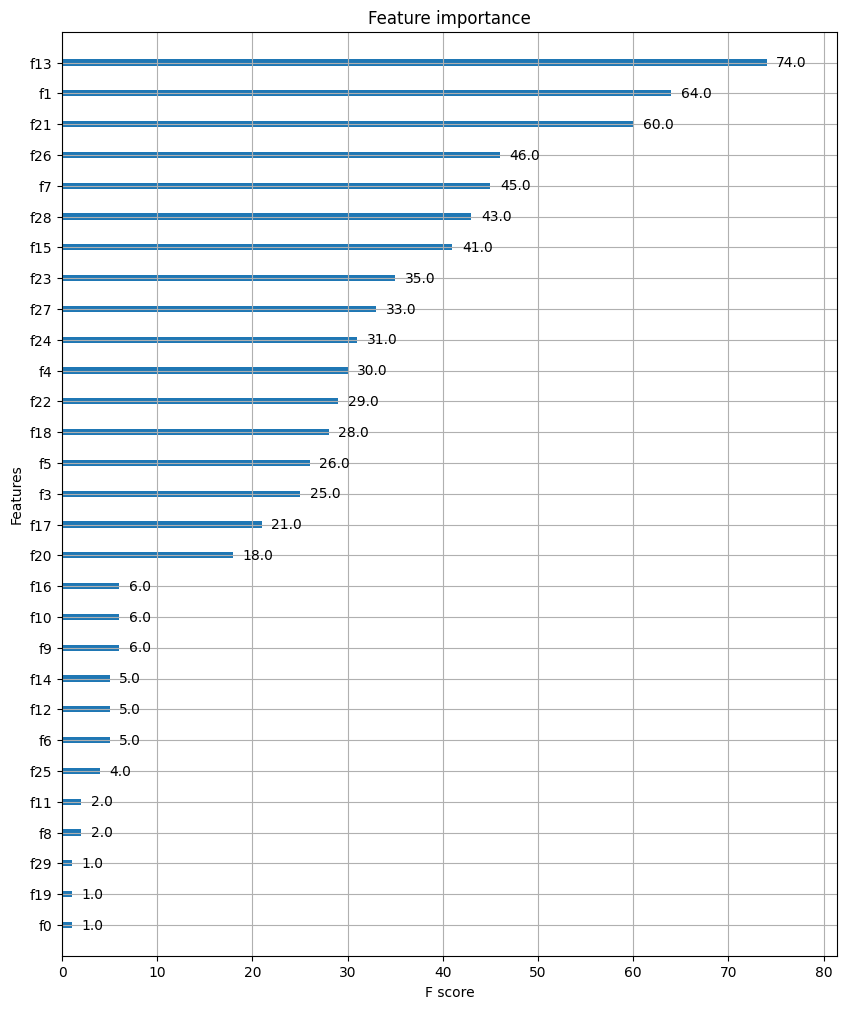

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax) 

* `xgboost.to_graphviz()` 이용: 트리 기반 규칙 구조 시각화 가능

* `xgboost.cv()`: GridSearchCV와 유사하게 데이터 세트에 대한 교차 검증 수행 후 파라미터를 구할 수 있는 방법 제공

    -> 반환값은 DataFrame

    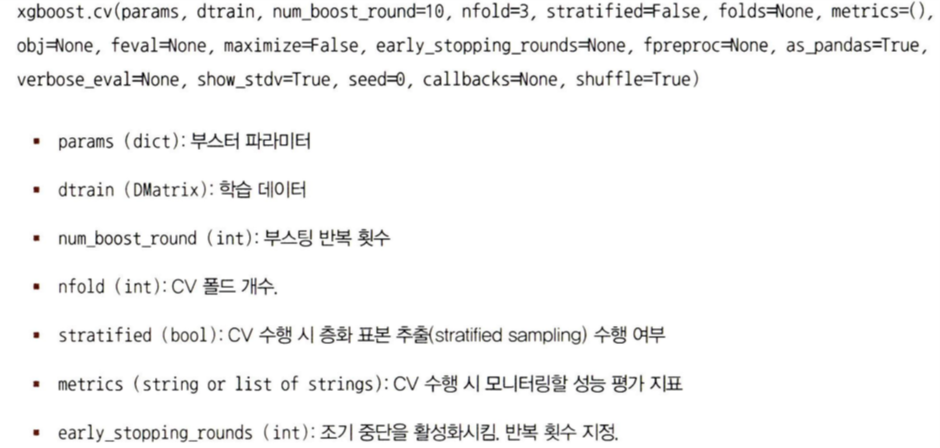

---

### **6-3. 사이킷런 래퍼 XGBoost의 개요 및 적용**

* 사이킷런의 다른 Estimator와 동일하게 fit()과 predict()만으로 학습과 예측이 가능하고, GridSearchCV, Pipleline 등 사이킷런의 다른 유틸리티를 그대로 사용 가능

* 종류: XGBClassifier, XGBRegressor

* 호환성을 위해  하이퍼 파라미터 변경

    * `eta` -> `learning_rate`

    * `sub_sample` -> `subsample`

    * `lambda` -> `reg_lambda`

    * `alpha` -> `reg_alpha`

    * `num_boost_round` -> `n_estimators`

In [ ]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC:0.9951


>> 앞의 파이썬 래퍼 XGBoost와 동일한 평가 결과가 나옴

* 사이킷런 래퍼 XGBoost에서도 조기 중단 수행 가능

    * 관련 파라미터: `early_stopping_rounds`, `eval_metric`, `eval_set`

    * 파라미터들을 fit()에 입력하면 됨

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

>> n_estimators를 400으로 설정해도 400번 반복을 수행하지 않고 311번 반복한 후 학습을 완료함

>> 211번 반복 시 logloss가 최소인데 그 뒤로 100번의 반복 동안 성능 평가 지수가 향상되지 않았기 때문에 반복을 멈춘 것

In [ ]:
# 조기 중단으로 학습된 XGBClassifier의 예측 성능
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC:0.9954


>> 조기 중단을 적용하지 않았을 때보다 약간 저조한 성능이지만 큰 차이는 아님

In [ ]:
# early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

>> 조기 중단값을 너무 급격하게 줄이면 예측 성능이 저하될 우려가 큼

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

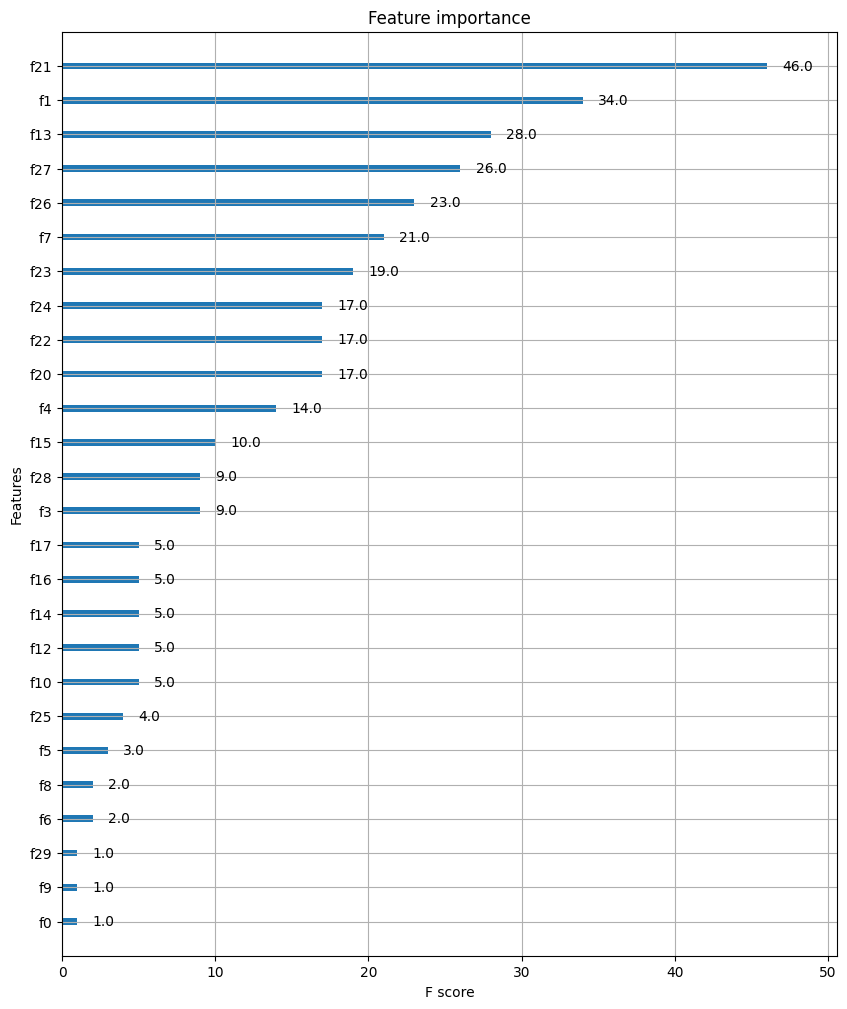

In [ ]:
# 피처 중요도 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=  plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

---

## **7. LightGBM**

* LightGBM: XGBoost와 함께 부스팅 계열 알고리즘에서 가장 각광을 받고 있음

* 장점: XGBoost보다 학습에 걸리는 시간이 훨씬 적음, 메모리 사용량도 상대적으로 적음, 성능은 XGBoost와 비슷하지만 기능상의 다양성은 더 많음, 카테고리형 피처의 자동 변환과 최적 분할

* 단점: 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉬움

* LightGBM은 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할 방식을 사용 (기존의 대부분 트리 기반 알고리즘은 균형 트리 분할 방식 사용)

    * 균형 트리 분할 방식: 최대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 트리의 깊이가 최소화 됨. 과적합 방지

    * 리프 중심 트리 분할 방식: 트리의 균형을 맞추지 않고 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리를 생성. 균형 트리보다 예측 오류 손실을 최소화 할 수 있음

    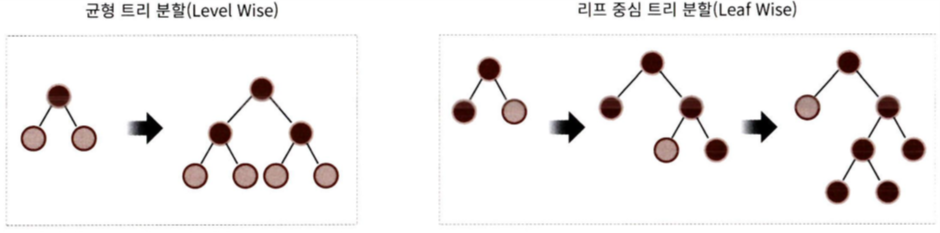


---

### **7-1. LightGBM 하이퍼 파라미터**

* LightGBM의 하이퍼 파라미터는 XGBoost와 많은 부분이 유사하지만 XGBoost와 다르게 리프 노드가 계속 분할되면서 트리의 깊이가 깊어지므로 이러한 트리의 특성에 맞는 하이퍼 파라미터 설정이 필요함

* 주요 파라미터

    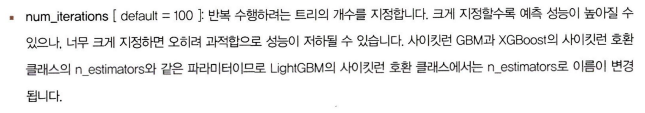

    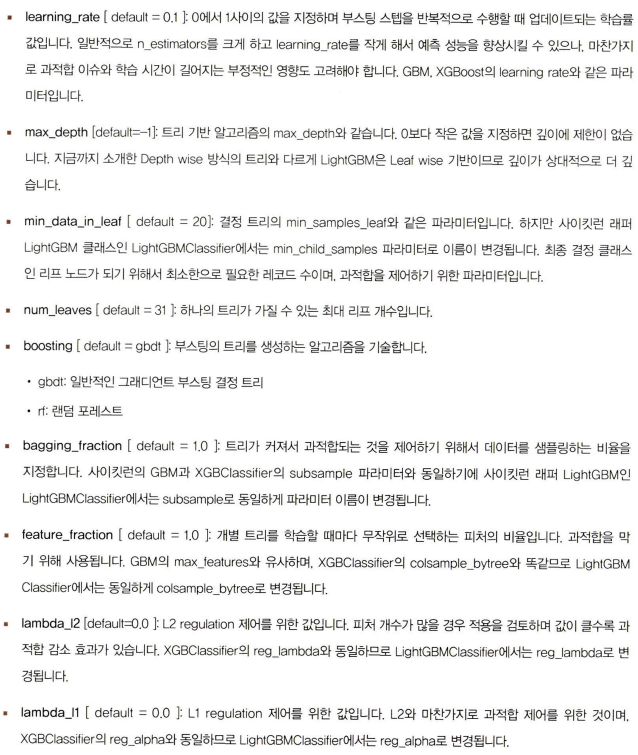


* Learning Task 파라미터

    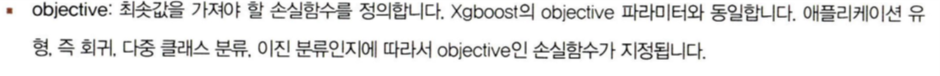

---

### **7-2. 하이퍼 파라미터 튜닝 방안**

* `num_leaves`의 개수를 중심으로 `min_child_samples`(`min_data_in_leaf`), `max_depth`를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안

    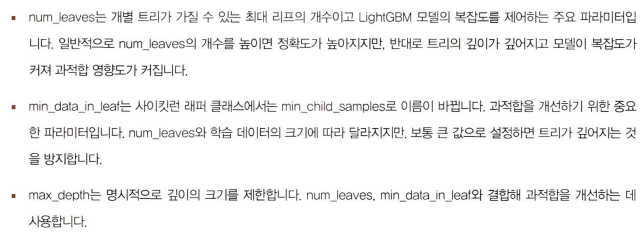


---

### **7-3. 파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 퍼라미터 비교**

* 사이킷런 래퍼 LightGBM 종류: `LGBMClassifier`, `LGBMRegressor`

* 사이킷런 래퍼 LightGBM 클래스는 사이킷런 래퍼 XGBoost 클래스의 하이퍼 파라미터와 거의 같음

    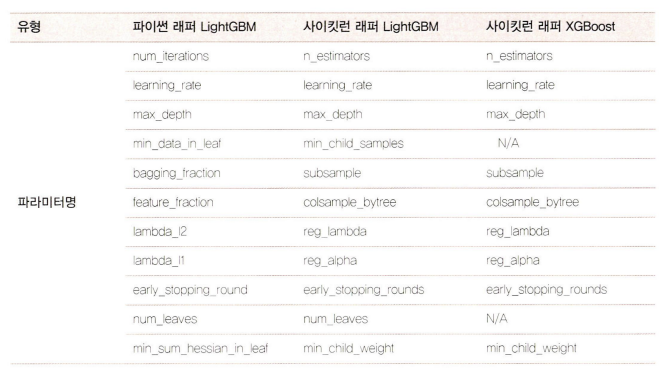

---

### **7-4. LightGBM 적용 - 위스콘신 유방암 예측**

In [ ]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출 
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', 
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

>> 조기 중단으로 145번 반복까지만 수행하고 학습을 종료

In [ ]:
# 예측 성능 평가
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870, F1: 0.9682, AUC:0.9905


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

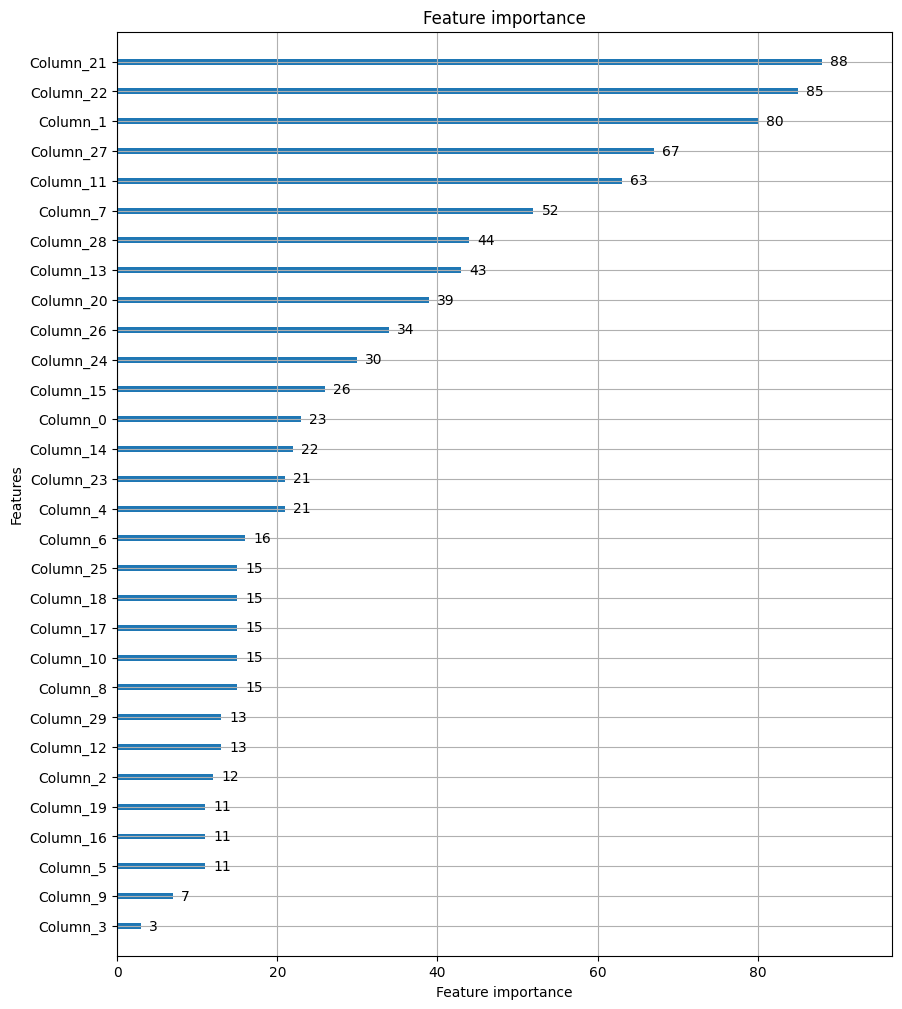

In [ ]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

>> 피처 순서대로 숫자를 붙여서 x축에 나열(Column_0: 첫 번째 피처, Column_1: 두 번째 피처)